In [17]:
import yt
from yt import YTArray
from astropy import constants as const
import sys
import h5py as h5
import trident
import numpy as np
from scipy.stats import wasserstein_distance
import os.path
import matplotlib
%matplotlib inline
import pickle
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import seaborn as sns
import palettable


import plotting_tools as pt
sns.set_style("white",{'font.family':'serif', 'axes.grid': True})
#for trident: git checkout 8b71bb81879a4d86b6d6c5e83c10971ece4e5d96
# for yt : git checkout ea857e75c2670fbb8f03de18017ff1a1b4a43e21
sys.path.append('../analysis')
import spectrum_generating_tools as spg
import spectrum_analysis_tools as spa

In [65]:
model = 'P0'
ray_id = 1
fit_file  = '../../data/analyzed_spectra/synth_%s%04d_eval.pickle'%(model, ray_id)
fit_data = pickle.load( open(fit_file, 'rb'))

# create dictionary
model_fits = {'ion':[], 'wavelength':[], 'flux':[]}
ovi_fit_vv = []
ovi_fit_flux =[] 
si_fit_vv = []
si_fit_flux = []
for fit in fit_data:
    fit_ion = fit['partials'][0][0][0]
    wl = fit['wavelength']
    fluxfit = fit['full']  
    
    if fit_ion == 'OVI':
        w0 = spa.restwave('OVI', 0.25)
        vvfit = pt.convert_to_vel(wl, w0)
        ovi_fit_vv = np.append(ovi_fit_vv, vvfit)
        ovi_fit_flux = np.append(ovi_fit_flux, fluxfit)
    elif fit_ion == 'SiIII':
        w0 = spa.restwave('SiIII', 0.25)
        vvfit = pt.convert_to_vel(wl, w0)
        si_fit_vv = np.append(si_fit_vv, vvfit)
        si_fit_flux = np.append(si_fit_flux, fluxfit)
    


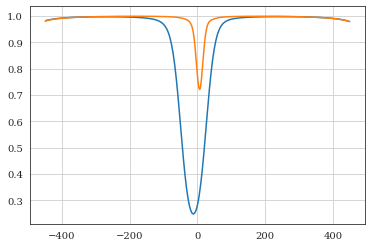

In [66]:
plt.plot(ovi_fit_vv, ovi_fit_flux)
plt.plot(si_fit_vv, si_fit_flux)


In [70]:
ovi_weights = 1-ovi_fit_flux
si_weights = 1-si_fit_flux

ovi_mask = ovi_weights > 0.05
si_mask = si_weights > 0.05

ovi_fit_vv = ovi_fit_vv[ovi_mask]
ovi_weights = ovi_weights[ovi_mask]

si_fit_vv = si_fit_vv[si_mask]
si_weights = si_weights[si_mask]

wasserstein_distance(ovi_fit_vv, si_fit_vv, u_weights = ovi_weights, v_weights = si_weights)
#ovi_mask = ovi_weights > 0.1
#si_mask = si_weights > 0.1
#wasserstein_distance(vv_ovi[ovi_mask], vv_si[si_mask], u_weights = ovi_weights[ovi_mask], v_weights = si_weights[si_mask])

23.257664597928933

P0
1
ERROR NO VPMODEL FITS FILE
P0
1
ERROR NO VPMODEL FITS FILE


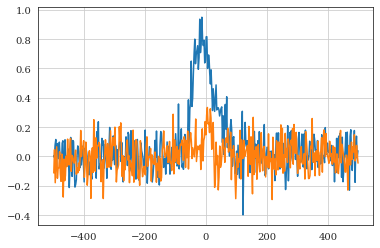

In [37]:
model = 'P0'
ray_id = 1
data_loc = '../../data/unanalyzed_spectra'
spec = 'COS-FUV_%s_z0.25_%04d'%(model, ray_id)

ion = 'OVI'
vv, flux, vvfit, fluxfit,  wl, wlfit, w0 = spa.load_velocity_data(ion, spec, 
                                    unanalyzed = True, work_dir = data_loc)
mask = np.abs(vv) < 500
vv_ovi = vv[mask]
flux_ovi = flux[mask]

ion = 'SiIII'
vv, flux, vvfit, fluxfit,  wl, wlfit, w0 = spa.load_velocity_data(ion, spec, 
                                    unanalyzed = True, work_dir = data_loc)
mask = np.abs(vv) < 500
vv_si = vv[mask]
flux_si = flux[mask]

plt.plot(vv_ovi, 1-flux_ovi)
plt.plot(vv_si, 1-flux_si)

In [39]:
ovi_weights = 1-flux_ovi
si_weights = 1-flux_si

ovi_mask = ovi_weights > 0.1
si_mask = si_weights > 0.1
wasserstein_distance(vv_ovi[ovi_mask], vv_si[si_mask], u_weights = ovi_weights[ovi_mask], v_weights = si_weights[si_mask])

90.88700983529554

In [ ]:
ion = 'OVI'
wl = fit['wavelength']
            fluxfit = fit['full']
            vvfit = pt.convert_to_vel(wl, w0)

            ax.plot(vvfit, fluxfit, color = 'black', linewidth = 5, alpha = 0.8)
            ax.plot(vvfit, fluxfit, color = color, linewidth = 2, alpha = 1)
            
vv_ovi = vv[vv<250]


ion = 'OVI'
wl = fit['wavelength']
            fluxfit = fit['full']
            vvfit = pt.convert_to_vel(wl, w0)

            ax.plot(vvfit, fluxfit, color = 'black', linewidth = 5, alpha = 0.8)
            ax.plot(vvfit, fluxfit, color = color, linewidth = 2, alpha = 1)
            
vv_ovi = vv[vv<250]

In [18]:
wasserstein_distance(vv[mask], vv[mask])

0.0

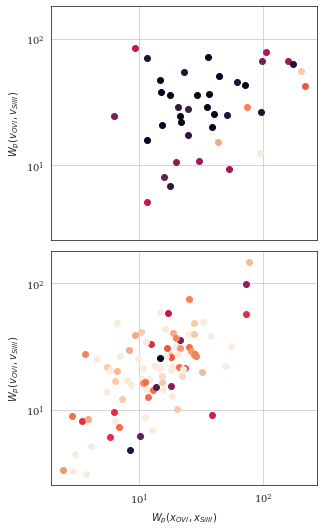

In [162]:

fig, axes = plt.subplots(nrows =2, ncols =1, figsize =(4.6, 7.5), sharey = True, sharex= True)
for sim, color, ax in zip(['P0', 'P0_agncr'], ['gray', 'orange'], [axes[0], axes[1]]):
    for ray_id in range(100):
        l, temperature, density, metallicity, vlos, ocol, sicol = \
            pt.load_sightline_scatter_data(sim, ray_id, output = 3195)
        l -= 250

        sim_ovi_col = np.sum(ocol)
        sim_si_col = np.sum(sicol)
        
        if sim_si_col < 1e12 or sim_ovi_col < 2e13:
            continue

        ocol_frac = ocol / sim_ovi_col
        si_frac = sicol / sim_si_col
        
        

        
        min_col_frac = 1e-2
        ocol_mask = ocol_frac > min_col_frac
        si_mask = si_frac > min_col_frac

        wp = 1

        vlos_w = wasserstein_distance(vlos[ocol_mask], vlos[si_mask], u_weights = ocol_frac[ocol_mask]**wp, v_weights = si_frac[si_mask]**wp)
        l_w = wasserstein_distance(l[ocol_mask], l[si_mask], u_weights = ocol_frac[ocol_mask]**wp, v_weights = si_frac[si_mask]**wp)


        
        #ax.scatter(vlos_w, l_w, c = sim_ovi_col)#, norm = LogNorm())#, vmin = 1e13, vmax = 1e15)
        ax.scatter(vlos_w, l_w, c = len(vlos[si_mask]), vmin = 2, vmax = 25)#, norm = LogNorm())#, vmin = 1e13, vmax = 1e15)

        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_ylabel('Spatial Wasserstein Metric')
        ax.set_ylabel('$W_p(v_{OVI}, v_{SiIII})$')

   # axes[1].set_xlabel('Kinematic Wasserstein Metric')
    axes[1].set_xlabel('$W_p(x_{OVI}, x_{SiIII})$')
fig.tight_layout()

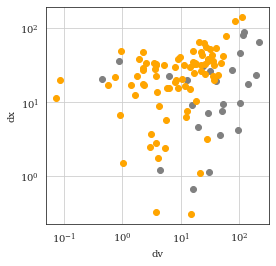

In [141]:

fig, ax = plt.subplots(figsize=(4,4))
for sim, color in zip(['P0', 'P0_agncr'], ['gray', 'orange']):
    for ray_id in range(100):
        l, temperature, density, metallicity, vlos, ocol, sicol = \
            pt.load_sightline_scatter_data(sim, ray_id, output = 3195)
        l -= 250

        sim_ovi_col = np.sum(ocol)
        sim_si_col = np.sum(sicol)
        
        if sim_si_col < 1e13 or sim_ovi_col < 2e13:
            continue

        ocol_frac = ocol / sim_ovi_col
        si_frac = sicol / sim_si_col

        
        min_col_frac = 1e-2
        ocol_mask = ocol_frac > min_col_frac
        si_mask = si_frac > min_col_frac

        wp = 1
        
        vlos_w = np.abs(np.median(vlos[ocol_mask]) - np.median(vlos[si_mask]))
        l_w = np.abs(np.median(l[ocol_mask]) - np.median(l[si_mask]))
      #  vlos_w = wasserstein_distance(vlos[ocol_mask], vlos[si_mask], u_weights = ocol_frac[ocol_mask]**wp, v_weights = si_frac[si_mask]**wp)
       # l_w = wasserstein_distance(l[ocol_mask], l[si_mask], u_weights = ocol_frac[ocol_mask]**wp, v_weights = si_frac[si_mask]**wp)

        ax.scatter(vlos_w, l_w, c = color)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('dv')
    ax.set_ylabel('dx')
plt.show()

In [82]:
vlos[ocol_mask]

array([ -3.45679691,   4.91792937,  -5.99016037,   6.94460429,
        -1.7732526 ,  16.26785248,  -5.88925699,   2.64358335,
        -9.45789285, -17.60989811, -21.56048529,  -0.32165315,
        -9.54393488,  -6.40790167,  19.82106219,  10.79621828,
        26.54594968,  86.88378955,  63.30564676])

In [83]:
vlos[si_mask]

array([81.92480439, 25.33878446])